# Spiking Neural Network (SNN): A probabilistic Model

# Loading packages

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import bernoulli
from multiprocessing import Pool
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings("ignore")

# USPS dataset

> USPS dataset, "usps.h5", is a _h5_ formated file and we us "h5py" package to load it. We assume it is saved in the current directory. Here, we load the train and test sets separately with their corresponding labels.

In [2]:
import h5py
with h5py.File('usps.h5', 'r') as hf:
        train = hf.get('train')
        X_tr = train.get('data')[:]
        y_tr = train.get('target')[:]
        test = hf.get('test')
        X_te = test.get('data')[:]
        y_te = test.get('target')[:]

# An example

Label: 7

Picture:


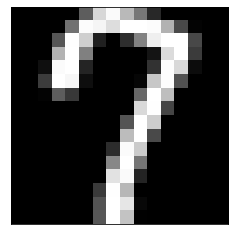

In [3]:
print(f"Label: {y_tr[3]}")
print()
print("Picture:")
plt.imshow(X_tr[3,:].reshape(16,16), interpolation='nearest', cmap='gray')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.show()

# Ones and sevens

### 500 training, 125 testing

> To test the accuracy of the following SNN classifier, the train and test set restricts to ones and sevens. In addition, similar to [[1]](https://arxiv.org/pdf/1910.01059.pdf), we use the first 500 cases from the train set and 125 cases from the test set. These choices allow us to compare the final accuracy with the reported one in [[1]](https://arxiv.org/pdf/1910.01059.pdf).

In [4]:
# Restricted train set
y2_tr = y_tr[(y_tr == 1) | (y_tr == 7)][:500]
# Restricted train labels
X2_tr = X_tr[(y_tr == 1) | (y_tr == 7),:][:500]
# Restricted test set
y2_te = y_te[(y_te == 1) | (y_te == 7)][:125]
# Restricted test labels
X2_te = X_te[(y_te == 1) | (y_te == 7),:][:125]

# Global parameters

In [5]:
# Number of output neoruns
neuron_numbers = 2
# Number of basis in forward filter
K = 12
# Spikes maximum steps
T = 32
# Rate encoding in Hz
Freq = 3
# Train set size
train_size = X2_tr.shape[0]
# Number of pixels in an image
image_size = X2_tr.shape[1]
# Test set size
test_size = X2_te.shape[0]

# Rate encoding

> Before directly clamping the images to the network inputs, we encode the USPS dataset by using  the _rate encoding_, denotes as "Freq", and defined in the above cell. 

> Each gray pixel is converted into an input spiking signal by generating an independent identically distributed (i.i.d.) Bernoulli vector of T samples, with the spiking probability takes as proportional to the pixel intensity. Besides, the probability is limited to be between zero and 0.5.

In [6]:
# For each 16 x 16 image, we need a 256 x T array to fill it with an iid sampled vector
trainset = np.zeros((train_size, image_size, T))
train_y = np.zeros((neuron_numbers, train_size, T))

for image_index in range(train_size):
    ############################################################
    #
    #    Train set lables
    #
    # Note: 1) We fill the true labels with a frequency of spikes
    #       denotes as Freq in Hz
    #       2) False labels are zero arrays
    if y2_tr[image_index] == 1:
        train_y[0, image_index, :] = np.array([ 1 if(i%Freq==0) else 0 for i in range(0, T)])
    else:
        train_y[1, image_index, :] = np.array([ 1 if(i%Freq==0) else 0 for i in range(0, T)])
    ############################################################
    #
    #    Train set images
    #    
    image = X2_tr[image_index,:]    
    for pixel_index in range(image_size):
        # For each pixel, the pixel intensity defines the sampling probability
        # Note: Image intesity is divided by 2 to keep the probability in [0, 0.5]
        trainset[image_index, pixel_index, :] = bernoulli.rvs(image[pixel_index]/2, size=T)        
        
testset = np.zeros((test_size, image_size, T))
for image_index in range(test_size):
    ############################################################
    #
    #    Test set images
    #   
    image = X2_te[image_index,:]
    for pixel_index in range(image_size):
        # For each pixel, the pixel intensity defines the sampling probability
        # Note: Image intesity is divided by 2 to keep the probability in [0, 0.5]
        testset[image_index, pixel_index, :] = bernoulli.rvs(image[pixel_index]/2, size=T)            

# Example: Lable

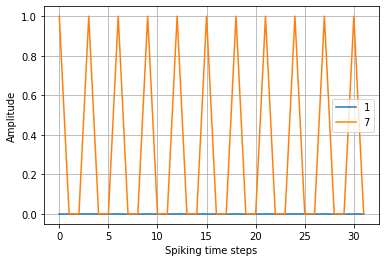

In [7]:
plt.plot(train_y[0, 0, :], label="1")
plt.plot(train_y[1, 0, :], label="7")
plt.grid()
plt.legend()
plt.xlabel("Spiking time steps")
plt.ylabel("Amplitude")
plt.show()

# Defining helper functions

In [7]:
def sigmoid(x):
    return np.array(1/(1+np.exp(-x)))

def convolution(f_t, g_t):
    ''' See eq. (4) below
    '''
    return np.dot(f_t, g_t[::-1])

# Filter Kernels

### Raised Cosine Kernels
> We use the cosin basis that are explianed in [[3]
](https://www.nature.com/articles/nature07140).

> Note that the time domian is in logarithmic scale. So, "this basis allows for the representation of fine temporal structure near the time of a spike and coarser/smoother dependency at later times"[[3]](https://www.nature.com/articles/nature07140)

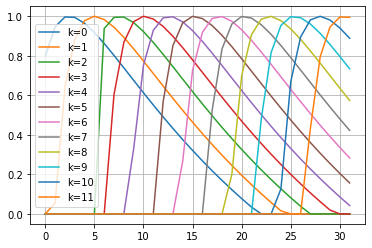

In [8]:
cosin_basis = np.zeros((K, T))
for k in range(K):    
    cosin_basis[k, :] = np.cos(np.log(-k/2 + 7*np.pi/6 + (2*np.arange(0, T)-T)*np.pi/(T)))
    # Negative values replaces by zero
    cosin_basis[k, cosin_basis[k, :] < 0 ] = 0    
    # We make sure the support of the filter is one and only one segment
    if k > 1 :
        cosin_basis[k, :(k+4)] = 0
    # Make sure there is non Nan in the array and replace them
    # by zero
    cosin_basis[k, :] = np.nan_to_num(cosin_basis[k, :])
    # Plot the curve 
    plt.plot(cosin_basis[k, :], label=f"k={k}")
    
plt.grid()
plt.legend()
plt.show()

# Convolution: Examples

> The convolutions of a sequence of spikes with repect to two positive cosine basis and one negative cosine basis are shown in the following. 

> The negative cosine basis can be used for feedback spikes.

Convolution of K = 1, 4.3458
Convolution of K = 8, 3.8220


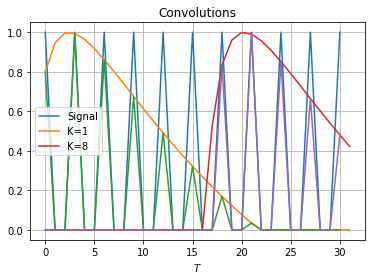

Convolution of K = 5, -4.2605


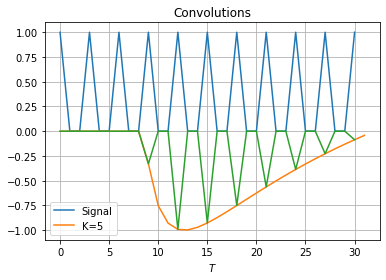

In [9]:
b = np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1])
print(f"Convolution of K = 1, {np.sum(cosin_basis[0,:b.shape[0]]*b[::-1]):.4f}")
print(f"Convolution of K = 8, {np.sum(cosin_basis[7,:b.shape[0]]*b[::-1]):.4f}")

plt.plot(b[::-1], label= "Signal")
plt.plot(cosin_basis[0,:], label = "K=1")    
plt.plot(cosin_basis[0,:b.shape[0]]*b[::-1])

plt.plot(cosin_basis[7,:], label = "K=8")    
plt.plot(cosin_basis[7,:b.shape[0]]*b[::-1])

plt.title("Convolutions")
plt.legend()
plt.xlabel(r"$T$")
plt.grid()
plt.show()

print(f"Convolution of K = 5, {np.sum(-cosin_basis[4,:b.shape[0]]*b[::-1]):.4f}")

plt.plot(b[::-1], label= "Signal")
plt.plot(-cosin_basis[4,:], label = "K=5")    
plt.plot(-cosin_basis[4,:b.shape[0]]*b[::-1])

plt.title("Convolutions")
plt.legend()
plt.xlabel(r"$T$")
plt.grid()
plt.show()

# Feedback Exponential Kernel

> An exponential feedback filter, as it was explained in [[1]](https://arxiv.org/pdf/1910.01059.pdf),  controls the immediate capability of spiking of a neuron.  

> Mathematically, it defines as $-\exp(-t/t_m)$ where $t_m$ denotes the scale length for exponential decay along the time domain. Here, we take $t_m = T/8$, where $T = 32$ is the maximum time steps in the simulation.

> Finally, the filter plot and its convolution with repect to a sequence of spikes are depicted.

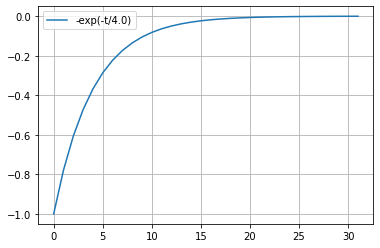

Convolution , -1.8948


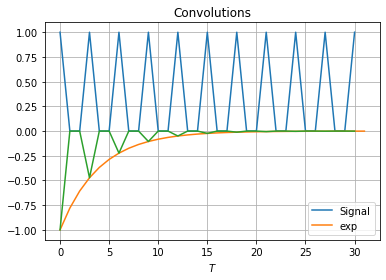

In [10]:
# Time scale
T_m = T/8
# Filter's array
exp_basis = np.zeros(T)
for t in range(T):
    exp_basis[t] = -np.exp(-t/T_m)

# Plot the filter
plt.plot(exp_basis, label=f"-exp(-t/{T_m:.1f})")    
plt.grid()
plt.legend()
plt.show()    

# Plot the convolution
b = np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1])
print(f"Convolution , {np.sum(exp_basis[:b.shape[0]]*b[::-1]):.4f}")

plt.plot(b[::-1], label= "Signal")
plt.plot(exp_basis, label = "exp")    
plt.plot(exp_basis[:b.shape[0]]*b[::-1])

plt.title("Convolutions")
plt.legend()
plt.xlabel(r"$T$")
plt.grid()
plt.show()

# NN topology: No Hidden Layer

> Using the mathemaical results in [[1]](https://arxiv.org/pdf/1910.01059.pdf), here we list all the relations that we shall use in the simulation. Note that numbers next to each equation can be found in the comment sections of the code.

> Below, you can see a diagram that shows a two neurons network. The top neorun, $i$, receives weighted input spikes at time $t$. The bias term, $\gamma_i$ and the feedback term, $\omega_i S_{i, \le t-1}$, correct the final value of the membrane potential, $u_{i,t}$, accordingly. Note that the feedback term depends on the neuron's previous states.

> Finally, depending on the threshold of the membrane potential, the neuron can spike at time step $t$.

![Network Diagram](./diagrams/network_draw_io.svg)

## Memberane potential, $u_{i, t}$ at time $t$:

## $u_{i, t} = \sum_{j \in \mathcal{P_j}} \omega_{j, i} \overrightarrow{s}_{j, t-1} + \omega_i \overleftarrow{s}_{i, t-1} + \gamma_i  \;\;\;\;\;\;\;\;\;\;\;\;\;$ (1)         

## where 
1. $\mathcal{P_j}$ is the set of pre-synaptic inputs for the neuron $i$.
2. $\omega_{j, i}$  is the feedforward weight for the input $j$ to the neuron $i$.
3. $\omega_i$ is the feedback weight for the neuron $i$.
4. $\gamma_i$ is the bias parameter.
5. $\overrightarrow{s}_{j, t-1} = a_t * s_{j, t-1}$ for feedforward filter basis $a_t$ (2).
6. $\overleftarrow{s}_{i, t-1} = b_t * s_{j, t-1}$ for feedback filter basis $b_t$ (3).
7. $f_t * g_t = \sum_{\delta \ge 0} f_{\delta} g_{t - \delta}$ is a convolution operator (4).


# Learning by Maximum log-likelihood estimation ([1])

### The gradiant of the log-liklihood w.r.t. parameter $\boldsymbol{\theta_i}$ for neuron $i$
$\newcommand{\ora}[1]{\overrightarrow{#1}}$
$\newcommand{\ola}[1]{\overleftarrow{#1}}$
### $\nabla_{\boldsymbol{\theta_i}} \mathcal{L}_{\boldsymbol{S}\le T}(\boldsymbol{\theta}) = \sum_{t=0}^{T} \nabla_{\boldsymbol{\theta_i}} \log P_{\boldsymbol{\theta_i}}  (s_i | \boldsymbol{s}_{\mathcal{P}_i \cup \{i\}, \le t-1})  \;\;\;\;\;\;\;\;\;\;\;\;\;$ (5)

#### Note: The individual entries for each time step $t$ contributes as the summand of the sum.

### The gradiant w.r.t. weights

### $\nabla_{\gamma_i} \log P_{\boldsymbol{\theta_i}}  (s_i | \boldsymbol{s}_{\mathcal{P}_i \cup \{i\}, \le t-1}) = s_{i,t} - \sigma(u_{i, t}),  \;\;\;\;\;\;\;\;\;\;\;\;\;$(6)

### $\nabla_{w_{i,j}} \log P_{\boldsymbol{\theta_i}}  (s_i | \boldsymbol{s}_{\mathcal{P}_i \cup \{i\}, \le t-1}) = \ora{s}_{j, t-1}(s_{i,t} - \sigma(u_{i, t})),   \;\;\;\;\;\;\;\;\;\;\;\;\;$(7)

### $\nabla_{w_{i}} \log P_{\boldsymbol{\theta_i}}  (s_i | \boldsymbol{s}_{\mathcal{P}_i \cup \{i\}, \le t-1}) = \ola{s}_{i, t-1}(s_{i,t} - \sigma(u_{i, t})),   \;\;\;\;\;\;\;\;\;\;\;\;\;$(8)

### where $\sigma(x) = 1/(1+\exp(-x))$


# Neuron Class:
> This class stores internal states of a neuron such as its previous memberance potentials. Calling the _output_ method moves the internal states one step forwrd. Similarly, calling the _gradiant_ method returns the MLE gradiant at time $t$ while moves the internal state one step forwrd.

> The _update_ method implements a fast version of SGD algorithm and updates the neuron weigths. By using [np.einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html) method, the following code provides a simple interface to switch to other architectures. For instance, [Pytorch](https://pytorch.org/) or [Tensorflow](https://www.tensorflow.org/) implement the same function and can exploit available GPUs for faster multiplications. Therefore, the code can be easily ported to those architecture.

In [14]:
class Neuron:
    def __init__(self, image_size, K, T, 
                 forward_basis, feedback_basis,
                 prob_threshold = .5):
        ''' Create a new instance of a Neuron object.
        
            image_size (integer): The size of an image array
            K (integer): Number of forward filter basis.
            T (integer): Maximum number of time steps
            forward_basis (np array): Pre-synoptic filter basis
            feedback_basis (np array): Post-synoptic filter basis
            prob_threshold (default 0.5): 
                 The threshold above which the neuron
                 fires and spike.                                   
        '''
        self.image_size = image_size
        self.K = K
        self.T = T
        self.prob_threshold = prob_threshold
        
        if len(feedback_basis.shape) == 1:
            self.feedbacks_K = 1
        else:
            self.feedbacks_K = K
        
        # Initialise weigths by sampling from Uniform(-1, 1)
        self.synaptic_ws = np.random.uniform(-1, 1, (image_size,  K))
        self.feedback_ws = np.random.uniform(-1, 1,  self.feedbacks_K)                    
        self.gamma = np.random.uniform(-1, 1)
        # Store filter basis
        self.forward_basis = forward_basis
        self.feedback_basis = feedback_basis
        # The inversion that is required for the convolusion is
        # time consuming in each SGD step. So, we construct an inversed
        # tensor now, and call it later, to achieve better performance 
        self.fast_forward_basis = np.zeros((K, T, T))
        for k in range(K):
            for t in range(1, T+1):
                segment = forward_basis[k, :t]
                self.fast_forward_basis[k, t-1, :t] = segment[::-1]
        #############################################
        # Internal states      
        #
        
        # This matrix stores $s_{j, t-1}$ in eq. (2)
        self.s_forward_t_1_s = np.zeros((image_size, K))
        # This value/array stores $s_{j, t-1}$ in eq. (3)
        if self.feedbacks_K == 1:
            self.s_feedback_t_1_s = np.zeros(1)        
        else:
            self.s_feedback_t_1_s = np.zeros(self.feedbacks_K) 
        # Previous spikes             
        self.previous_spikes = np.zeros(self.T +1)
        
        
           
    def output(self, image, t):
        ''' This method returns the membrane potential
            and changes the internal states of the neuron.
            
            Note: This method is for demonstration only. No performance
                  consideration is included here.
            
            image (np array (image_size x T)): The encoded image matrix
            t (integer): Time is zero based, so, t referes to the current
                         time and must start from 1.                         
        '''        
        # loop over filter basis
        for k in range(self.K):
            # loop over the pixels
            for j in range(self.image_size):
                spikes = image[j, :t]                    
                # contribution from j input                                          
                # Convolution, see eq. (2)
                self.s_forward_t_1_s[j, k] = convolution(self.forward_basis[k, :t], spikes)
                # Check the validity of the outputs
                if np.isnan(self.s_forward_t_1_s[j, k]):
                    print(f"NAN s_forward i={self.i}, j={j}, k={k}")
                    raise ValueError
                if np.isinf(self.s_forward_t_1_s[j, k]):
                    print(f"Inf s_forward i={self.i}, j={j}, k={k}")
                    raise ValueError
                    
            # At time t = 1, we take the previous spike as zero
            # So, the feedback is zero too.
            if self.feedbacks_K > 1:
                # Feedback contribution
                # The array previous_spikes contains the history of pulses that
                # has been emitted from the neorun.
                # Convolution, see eq. (3)
                self.s_feedback_t_1_s[k] = convolution(self.feedback_basis[k, :t], self.previous_spikes[:t])  
        
        # At time t = 1, we take the previous spike as zero
        # So, the feedback is zero too.                        
        if self.feedbacks_K ==1:
            # Feedback contribution
            # The array previous_spikes contains the history of pulses that
            # has been emitted from the neorun.
            # Convolution, see eq. (1) 
            self.s_feedback_t_1_s = convolution(self.feedback_basis[:t], self.previous_spikes[:t]) 
            
        # Calculating membrane potential
        # This is the sum of contributions from
        # inputes, feedback and bias.
        # See eq. (1)
        u_i = (
               np.sum(self.synaptic_ws*self.s_forward_t_1_s)
             + np.sum(self.feedback_ws*self.s_feedback_t_1_s)                 
             + self.gamma
        )
        # Check the validity of u_i
        if np.isinf(u_i):
            print(f"Inf u_i i={self.i}")
            raise ValueError 
        
        # According to the value of sigmoid(u_i) and spike threshold,
        # the neuron fires. We store this internal state in  previous_spikes array.
        # In the next time step, we use it to find the convolution of the feedback signal.
        self.previous_spikes[t] = 1 if sigmoid(u_i) >= self.prob_threshold else 0
           
        return u_i
    
    def gradiant(self, s_i, image, t):
        ''' The gradiant method moves the internal state
            one step forward, while it returns the gradiants
            with respect the weights
            
            s_i (0 or 1): the true label at time t.
            image (np array (image_size x T)): The encoded image matrix
            t (integer): Time is zero based, so, t referes to the current
                         time and must start from 1. 
        '''
        # Eq. (6)        
        diff = s_i - sigmoid(self.output(image, t))        
        g_bias = diff            
        # Eq. (7)
        g_synaptic_ws = self.s_forward_t_1_s*diff        
        # Eq. (8)
        g_feedback_ws = self.s_feedback_t_1_s*diff
        
        return (g_bias, g_synaptic_ws, g_feedback_ws)
    
    def memb(self, image):
        ''' Returns neorun's membrane potential for 
            all time steps.
            
            image (np array (image_size x T)): The encoded image matrix
        '''
        self.previous_spikes = np.zeros(self.T +1)
        return np.array([self.output(image, t) for t in range(1, self.T)])
    
    def probs(self, image): 
        ''' Returns neorun's probability of firing an spike for 
            all time steps.
            
            image (np array (image_size x T)): The encoded image matrix
        '''
        return sigmoid(self.memb(image))
    
    def spikes(self, image):
        ''' Returns neorun's spikes for 
            all time steps.
            
            image (np array (image_size x T)): The encoded image matrix
        '''
        return np.where(self.probs(image) >= self.prob_threshold, 1, 0)
    
    def output_f(self, image):
        ''' Fast version of the output method.
            it returns an np array size T of u_i
        ''' 
        s_forward_T = np.einsum('ijk, lk -> jli', self.fast_forward_basis, image)
        forward_T = np.einsum('ijk, jk -> i', s_forward_T, self.synaptic_ws)
        u_i = forward_T + self.gamma
        
        
        if self.feedbacks_K > 1:
            s_feedback_T = np.zeros((K,T))
            for t in range(1, T):
                s_feedback_T[:, t] = np.einsum('ij, j -> ',
                                               self.feedback_basis[:,:t], 
                                               np.where(u_i[:t][::-1]>= self.prob_threshold, 1, 0))   
                u_i[t] += np.einsum('ij, ij -> ', s_feedback_T[:, t], self.feedback_ws)
        else:
            s_feedback_T = np.zeros(T)
            # Feedback contribution
            # Convolution, see eq. (1) 
            for t in range(1, T):
                s_feedback_T[t] = np.einsum('j, j -> ',
                                            self.feedback_basis[:t], 
                                            np.where(u_i[:t][::-1]>= self.prob_threshold, 1, 0)) 
                u_i[t] += self.feedback_ws*s_feedback_T[t]
        
        return u_i
    
    def probs_f(self, image):
        ''' Returns neorun's probability of firing an spike for 
            all time steps (fast version).
            
            image (np array (image_size x T)): The encoded image matrix
        '''
        return sigmoid(self.output_f(image))
    
    def spikes_f(self, image):
        ''' Returns neorun's spikes for 
            all time steps (fast version).
            
            image (np array (image_size x T)): The encoded image matrix
        '''
        return np.where(self.probs_f(image) >= self.prob_threshold, 1, 0)
        
    def update(self, image, label, eta):
        ''' This method runs a single SGD step on single image
            and update weight matrices (fast).
            
            image (np array (image_size x T)): The encoded image matrix
            label (np array (T)): The output's truth values 
            eta (float, smaller than one): The learning rate
        ''' 
        # Find the convolution, eq. (2)
        s_forward_T = np.einsum('ijk, lk -> jli', self.fast_forward_basis, image)
        # Pre-synaptic contribution
        # first term in eq. (1) sum
        forward_T = np.einsum('ijk, jk -> i', s_forward_T, self.synaptic_ws)
        # Partial sum in eq. (1)
        u_i = forward_T + self.gamma
        
        # Calculating feedback contribution needs the 
        # membrane potential in the previous steps.
        # So, the cummulative sum of the previous u_i
        # finds the feedback convolution
        if self.feedbacks_K > 1:
            s_feedback_T = np.zeros((K,T))
            for t in range(1, T):
                # The convolution of previous spikes and previous spikes
                # Eq. (3)
                s_feedback_T[:, t] = np.einsum('ij, j -> i',
                                               self.feedback_basis[:,:t], 
                                               #np.where(u_i[:t][::-1] >= self.prob_threshold, 1, 0))                 
                                               np.where(sigmoid(u_i[:t][::-1]) >= self.prob_threshold, 1, 0))                 
                # Update u_i by adding the feedback contribution, eq. (1)
                u_i[t] += np.einsum('i, i -> ', s_feedback_T[:, t], self.feedback_ws)
        else:
            s_feedback_T = np.zeros(T)            
            for t in range(1, T):
                # The convolution of previous spikes and previous spikes
                # Eq. (3)
                s_feedback_T[t] = np.einsum('j, j -> ',
                                            self.feedback_basis[:t], 
                                            #np.where(u_i[:t][::-1] >= self.prob_threshold, 1, 0))
                                            np.where(sigmoid(u_i[:t][::-1]) >= self.prob_threshold, 1, 0))
                # Update u_i by adding the feedback contribution, eq. (1)
                u_i[t] += self.feedback_ws*s_feedback_T[t]
        # Gradiant  
        # Eq. (6)
        g_bias = label - sigmoid(u_i) 
        self.gamma += eta*np.sum(g_bias)
        # Eq. (7)
        self.synaptic_ws += eta*np.einsum('ijk, i -> jk', s_forward_T, g_bias )        
        # Eq. (8)
        if self.feedbacks_K > 1:
            self.feedback_ws += eta*np.einsum('ij, j -> i', s_feedback_T, g_bias) 
        else:
            self.feedback_ws += eta*np.dot(s_feedback_T, g_bias )                
            
        return (u_i, np.sqrt(np.sum(g_bias**2)))
    
    
    def batch_update(self, images, labels, eta, batch_size):
        ''' This method runs a single SGD step on a batch of images
            and update weight matrices (fast).
            
            images (np array (batch_size x image_size x T)): The encoded image matrix
            labels (np array (batch_size x T)): The outputs' truth values 
            eta (float, smaller than one): The learning rate
            batch_size
        ''' 
        # Find the convolution, eq. (2)
        s_forward_T = np.einsum('ijk, lmk -> ljmi', self.fast_forward_basis, images)
        # Pre-synaptic contribution
        # first term in eq. (1) sum
        forward_T = np.einsum('ijkl, kl -> ij', s_forward_T, self.synaptic_ws)
        # Partial sum in eq. (1)
        u_i = forward_T + self.gamma
        
        # Calculating feedback contribution needs the 
        # membrane potential in the previous steps.
        # So, the cummulative sum of the previous u_i
        # finds the feedback convolution
        if self.feedbacks_K > 1:
            s_feedback_T = np.zeros((batch_size, K, T))
            for t in range(1, T):
                # The convolution of previous spikes and previous spikes
                # Eq. (3)
                s_feedback_T[:, :, t] = np.einsum('ij, kj -> ki',
                                               self.feedback_basis[:,:t],                 
                                               np.where(sigmoid(u_i[:, :t][:, ::-1]) >= self.prob_threshold, 1, 0))                 
                # Update u_i by adding the feedback contribution, eq. (1)
                u_i[:, t] += np.einsum('ij, j -> i', s_feedback_T[:, :, t], self.feedback_ws)
        else:
            s_feedback_T = np.zeros((batch_size, T))            
            for t in range(1, T):
                # The convolution of previous spikes and previous spikes
                # Eq. (3)
                s_feedback_T[:, t] = np.einsum('j, lj -> l',
                                            self.feedback_basis[:t], 
                                            np.where(sigmoid(u_i[:, :t][:, ::-1]) >= self.prob_threshold, 1, 0))
                # Update u_i by adding the feedback contribution, eq. (1)
                u_i[:, t] += self.feedback_ws*s_feedback_T[:, t]
        # Gradiant  
        # Eq. (6)
        g_bias = labels - sigmoid(u_i) 
        self.gamma += eta*np.sum(g_bias)
        # Eq. (7)
        self.synaptic_ws += eta*np.einsum('ijkl, ij -> kl', s_forward_T, g_bias )        
        # Eq. (8)
        if self.feedbacks_K > 1:
            self.feedback_ws += eta*np.einsum('ijk, ik -> j', s_feedback_T, g_bias) 
        else:
            self.feedback_ws += eta*np.einsum('ij, ij -> ',s_feedback_T, g_bias )                
            
        return (u_i, np.sqrt(np.sum(g_bias**2)))
    

# Helper method

> The following method simplifies the instantiation of a neuron class.

In [12]:
def init_ws(image_size, K, T, cosin_feedback = True, seed=44):
    '''Returns a higher order function that can create aNeorun object.
    '''
    if seed is not None:
        np.random.seed(seed)    
    
    def init_neuron_cosine(i):
        '''Create a single neuron with
           inversed cosin basis for feedback
        '''
        return Neuron(image_size, K, T, 
                      cosin_basis, -cosin_basis)
    
    def init_neuron_exp(i):
        '''Create a single neuron with
           exp basis for feedback
        '''
        return Neuron(image_size, K, T, 
                      cosin_basis, exp_basis)
    if cosin_feedback:
        return init_neuron_cosine
    else:
        return init_neuron_exp



# Learning by Gradiant

### Note: The following is for demonstration only. Performance-wise, the _output_ method is slow.

> Here, we use the gradiants calculated in eq. (6), (7) and (8), and then, update the the neurons weights. Since this is for demonstration purpose, it runs for 10 epochs. 

> We see that the error decreases after ten epochs.

In [55]:
# Method to make a new neorun object
init_neuron = init_ws(image_size, K, T, cosin_feedback = False, seed=43)
# Selct one image and its corresponding label
image_index = 0
image = trainset[image_index, :, :]         
label = train_y[:, image_index, :] 
# Learning rate
eta = 0.25
# Maximum epoch
max_epoch = 10
# Error array
Error_S = np.zeros((2, max_epoch))
# Network
network = [None, None]
# Loop over neorons
for i in range(neuron_numbers):
    neuron = init_neuron(i)
    network[i] = neuron
    
    for epo in range(max_epoch):    
        # find the gradiant for a single image
        gradiants = np.array([neuron.gradiant(label[i, t-1], image, t) for t in range(1, T)])
        # error squared
        Error_S[i, epo] = np.sum(gradiants[:, 0]**2)        
        #
        g_bias = np.sum(gradiants[:, 0])
        g_synaptic_ws = np.sum(gradiants[:, 1])
        g_feedback_ws = np.sum(gradiants[:, 2])        
        # Update the weigths of the neoron
        # decrease the size of the learning rate as the training goes on        
        neuron.gamma += eta*g_bias/(epo+1)
        neuron.synaptic_ws += eta*g_synaptic_ws/(epo+1)
        neuron.feedback_ws += eta*g_feedback_ws/(epo+1) 
        
print(f"Starting root error square for both neoruns: {Error_S[0, 0]:.3}, {Error_S[1, 0]:.3}")
print(f"  Ending root error square for both neoruns: {Error_S[0, -1]:.3}, {Error_S[1, -1]:.3}")
                

Starting root error square for both neoruns: 30.4, 20.0
  Ending root error square for both neoruns: 0.0, 13.0


# Now, we overfit the model for a single image

> To check the code and its overal behaviour, it is usefull to overfit the model for a single image. Training the model for a long enough epoch results in an overfitted model that must reproduce the exact output similar to the true label in the training phase.

> The result is a kind of assurance that every bits and pieces of the code works properly and smoothly.

# Overfitting

> To test the model, we select a single image and overfit the network. Then, we must get the exact ouput from the trained model if we use the image again. This time, we use the faster _update_ method.

In [104]:
# Method to make a new neorun object
init_neuron = init_ws(image_size, K, T, cosin_feedback = False, seed=42)
# Selct one image and its corresponding label
image_index = 0
image = trainset[image_index, :, :]         
label = train_y[:, image_index, :] 
# Learning rate
eta = 0.5
# Maximum epoch
max_epoch = 400
# Error array
Error_S = np.zeros((2, max_epoch))
# Network
network = [None, None]
for i in range(neuron_numbers):
    neuron = init_neuron(i)
    network[i] = neuron
    
    for epo in range(max_epoch):   
        # Update the neorun in place
        _, errs = neuron.update(image, label[i, :], eta/(epo+1))
        Error_S[i, epo] = np.sum(errs**2)                        
        # Early stop
        if Error_S[i, epo] < 1e-1:
            break

# Check the output of the trained model

> We feed the signle image that we used to train the model, for demonstration purpose (It never happens in real modelling). We expect to get the same rate encoding frequecny for the true case and zero for the false one.

> As we can see, the moving average rate function is exactly the same as the label, and the average is the same in the first significant figure.

In [105]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

str_first = "first"
str_second = "second"
print(f"Label: {y2_tr[image_index]}, so the { str_first if(y2_tr[image_index] == 1) else str_second}" 
      f" neuron predicts the True rate.")
#print(f"The rate encoding that we used for training model: {(1/p):.3f}")
print(f"The rate encoding that we used for first : {np.mean(moving_average(label[0,:], Freq)):.3f}")
print(f"The rate encoding that we used to train the model: {np.mean(moving_average(label[1,:], Freq)):.3f}")

n1 = network[0]
n2 = network[1]

n1_spikes = n1.spikes(image)
n2_spikes = n2.spikes(image)

n1_pred = np.sum(n1_spikes)/len(n1_spikes)
n2_pred = np.sum(n2_spikes)/len(n2_spikes)

print(f"The moving average rate encoding of the first neuron output: {np.mean(moving_average(n1_spikes, Freq)):.3f}")
print(f"The moving average rate encoding of the second neuron output: {np.mean(moving_average(n2_spikes, Freq)):.3f}")

print(f"The average rate encoding of the first neuron output: {n1_pred:.3f}")
print(f"The average rate encoding of the second neuron output: {n2_pred:.3f}")

Label: 7, so the second neuron predicts the True rate.
The rate encoding that we used for first : 0.000
The rate encoding that we used to train the model: 0.333
The moving average rate encoding of the first neuron output: 0.000
The moving average rate encoding of the second neuron output: 0.333
The average rate encoding of the first neuron output: 0.000
The average rate encoding of the second neuron output: 0.355


# Decreasing global root error squared during the learning 

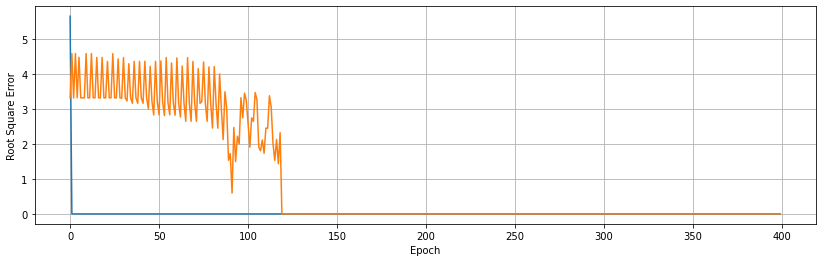

In [106]:
fig = plt.figure(figsize=(14, 4))

plt.plot(np.sqrt(Error_S[0,:]))
plt.plot(np.sqrt(Error_S[1,:]))
plt.xlabel("Epoch")
plt.ylabel("Root Square Error")
plt.grid()


# The spike outputs

> And the outputs of the neurons.

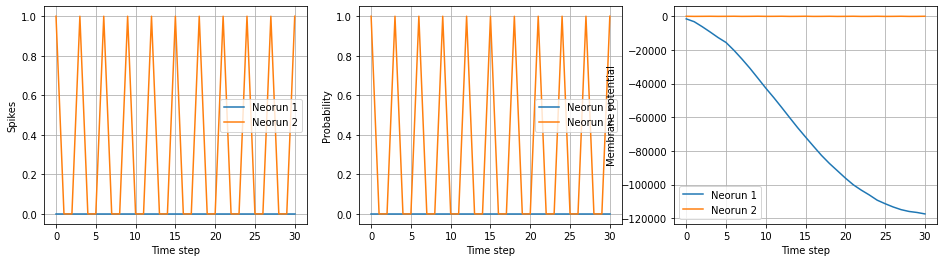

In [107]:
n1 = network[0]
n2 = network[1]

fig = plt.figure(figsize=(16, 4))
plt.subplot(131)

plt.plot(n1.spikes(image), label="Neorun 1")
plt.plot(n2.spikes(image), label="Neorun 2")
plt.ylabel("Spikes")
plt.xlabel("Time step")
plt.legend()
plt.grid()

plt.subplot(132)
plt.plot(n1.probs(image), label="Neorun 1")
plt.plot(n2.probs(image), label="Neorun 2")
plt.ylabel("Probability")
plt.xlabel("Time step")
plt.legend()
plt.grid()

plt.subplot(133)
plt.plot(n1.memb(image), label="Neorun 1")
plt.plot(n2.memb(image), label="Neorun 2")
plt.ylabel("Membrane potential")
plt.xlabel("Time step")
plt.legend()
plt.grid()
plt.show()

# Plot the pre-synaptics weights 

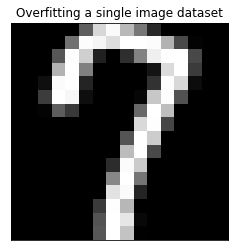

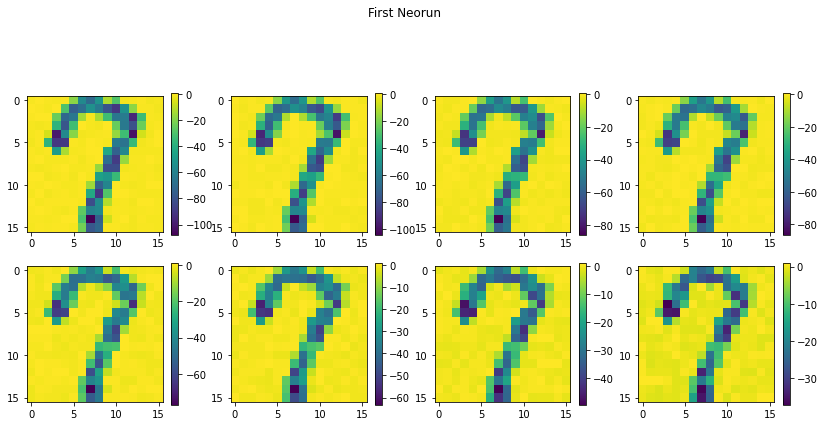

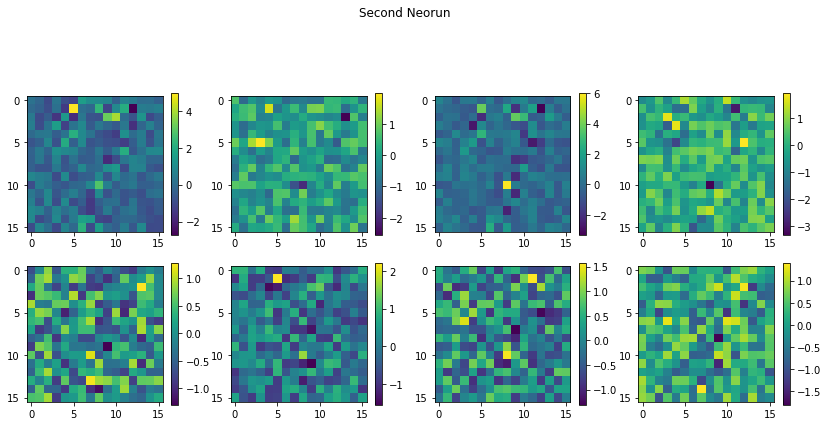

In [108]:
plt.imshow(X_tr[3,:].reshape(16,16), interpolation='nearest', cmap='gray')
plt.title("Overfitting a single image dataset")
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.show()

for j in [0,1]:
    neorun = network[j]
    fig = plt.figure(figsize=(14, 12))
    if j == 0: 
        plt.suptitle("First Neorun") 
    else:
        plt.suptitle("Second Neorun")
    
    gs=GridSpec(4,4)
    for i in range(8):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        plt.imshow(neorun.synaptic_ws[:,i].reshape((16,16)), interpolation='nearest')
        plt.colorbar()
    plt.show()

## Batch SGD, utilising multiprocessor architecture

> In the following code, the training of the neurons is distributed over cpu cores. It is implemented in _parallel_learning_ method.

In [109]:
# lerning rate
etas = [0.5, 0.5]
# maximum epoch
epoch = 200
# batch size
batch_size = 20

global_errors = np.zeros((neuron_numbers, epoch))
# A single neuron finds it MLE gradiants
# over the batch
def parallel_learning(args):    
    labels = args[0]    
    images = args[1]
    neuron = args[2]
    eta = args[3]    
    batch_len = images.shape[0]
    errors = np.zeros(batch_len)   
    ui, errs = neuron.batch_update(images, labels, eta, batch_len)                    
    return (neuron, errs, ui)



image_indices = [image_index in range(train_size)]
init_neuron = init_ws(image_size, K, T, cosin_feedback = False, seed=43)

network = []
for i in range(neuron_numbers):
    network += [init_neuron(i)]

for epo in range(epoch):
    
    #shuffle the training set at the start of each epoch
    np.random.shuffle(image_indices)   
    errors = np.zeros(neuron_numbers)
    for i_start in range(0, train_size, batch_size):
        batch_indices = list(range(i_start, min(i_start+batch_size, train_size)))
        images = trainset[batch_indices, :, :]
        labels = train_y[:, batch_indices, :]          
        params = [(labels[i, :, :], images, network[i], etas[i]/ (1 + epo)) for i in range(neuron_numbers)] 
         
        with Pool(neuron_numbers) as pool:
            parallel_result = pool.map(parallel_learning, params)
            
        for i in range(neuron_numbers):
            neuron, err, ui = parallel_result[i]            
            errors[i] += np.sum(err)
            network[i] = neuron            
            
    global_errors[:, epo] = errors
   


# Global root error squared

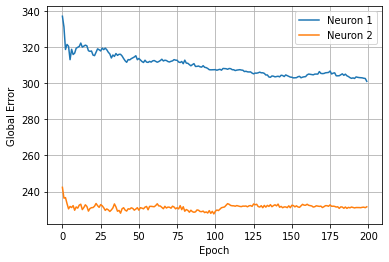

In [110]:
plt.plot(np.abs(global_errors[0, :]), label="Neuron 1")
plt.plot(np.abs(global_errors[1, :]), label="Neuron 2")
plt.xlabel("Epoch")
plt.ylabel("Global Error")
plt.grid()
plt.legend()
plt.show()

# Accuray vs. spike signal duration

> See that we replicate the same accuracy that wes reported in [[1]](https://arxiv.org/pdf/1910.01059.pdf).

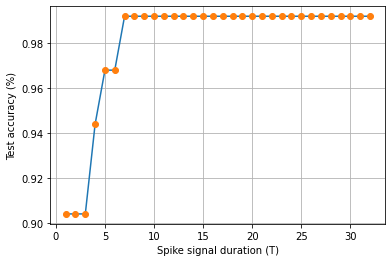

In [119]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

n1 = network[0]
n2 = network[1]
p = 1/Freq

accuracies = np.zeros(T)
for t in range(1, T+1):
    TP = 0
    for image_index in range(test_size):
        image  = testset[image_index,:,:]

        label = y2_te[image_index]
        
        pred_1 = np.mean(moving_average(n1.spikes_f(image)[:t], Freq))
        pred_2 = np.mean(moving_average(n2.spikes_f(image)[:t], Freq))
        #print(label, pred_1, pred_2)
        if np.abs(p - pred_1) < np.abs(p - pred_2) and label == 1:
            TP  += 1
        elif np.abs(p - pred_1) > np.abs(p - pred_2) and label == 7:
            TP  += 1
    accuracies[t-1] = TP/test_size
    
    
plt.plot(range(1, T+1), accuracies)
plt.plot(range(1, T+1), accuracies, 'o')
plt.xlabel("Spike signal duration (T)")
plt.ylabel("Test accuracy (%)")
plt.grid()
plt.show()
    

# Example: Spiking output for test set

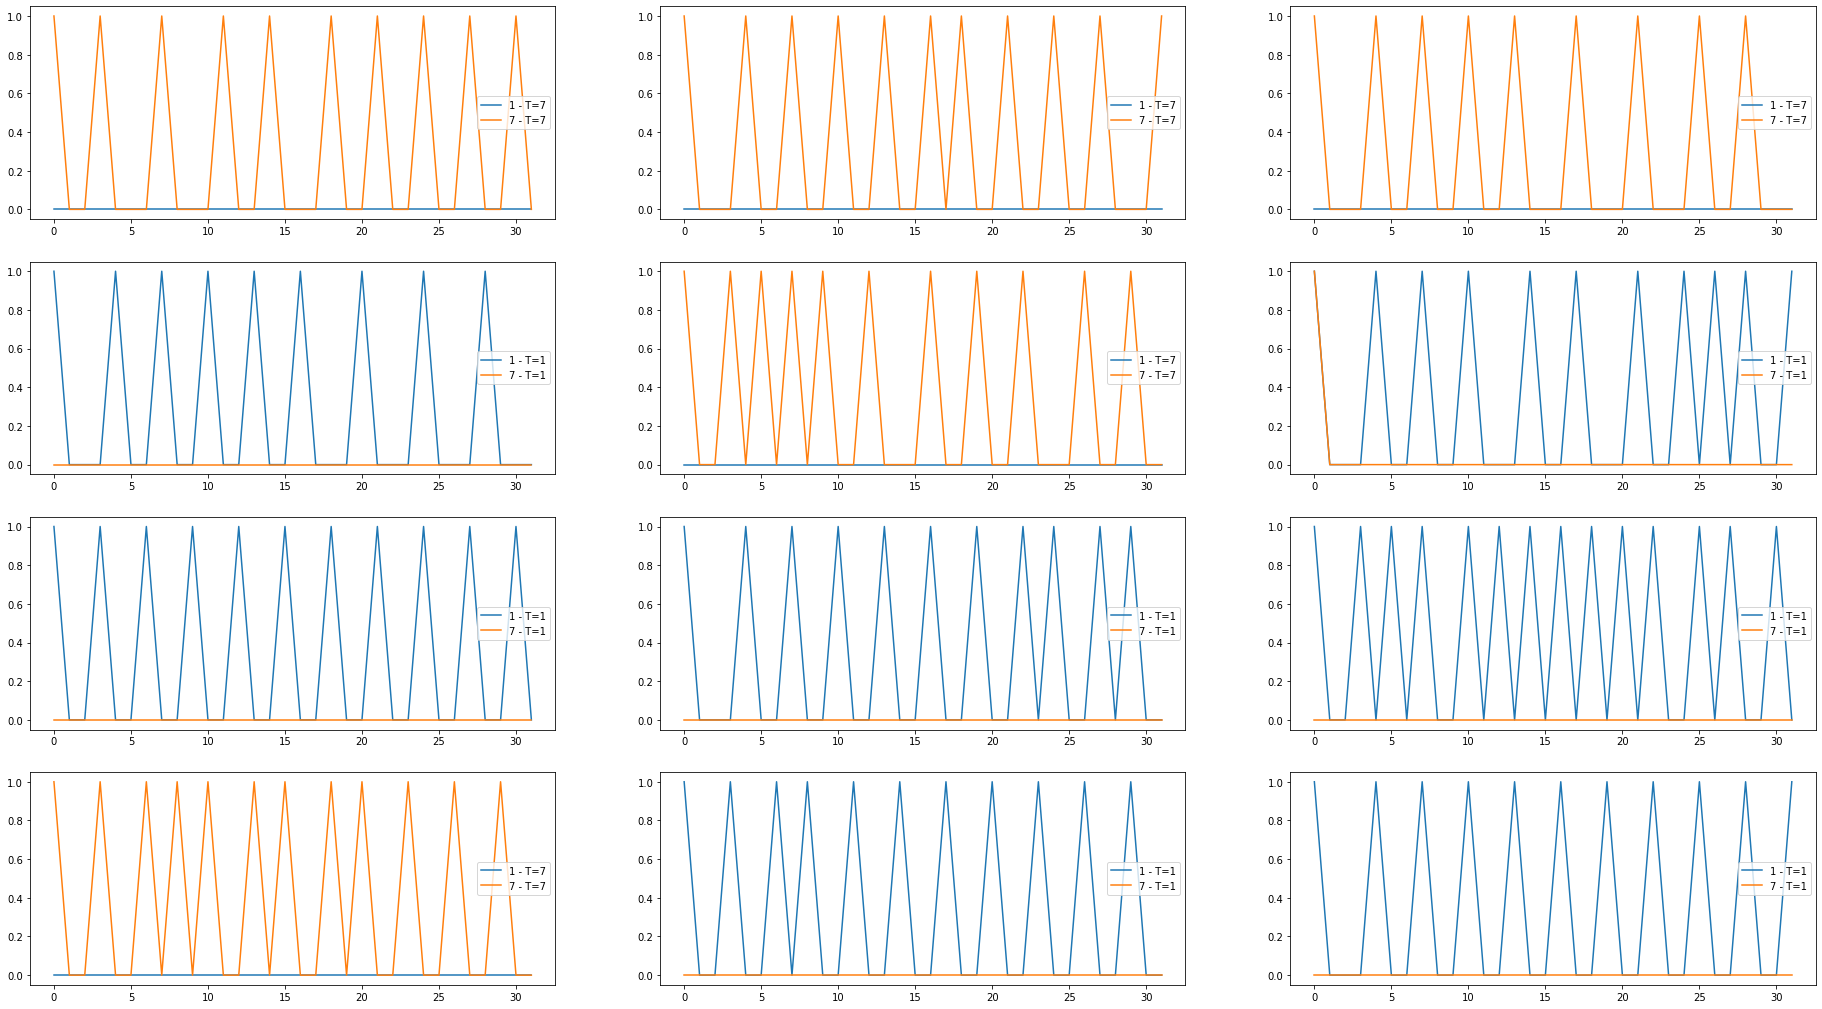

In [123]:
n1 = network[0]
n2 = network[1]
fig = plt.figure(figsize=(32,18))

for i in range(4):
    for j in range(3):
        image_index = j + i*3 + 1 
        plt.subplot(4, 3, image_index)
        plt.plot(n1.spikes_f(testset[image_index,:,:]), label=f"1 - T={y2_te[image_index]}")
        plt.plot(n2.spikes_f(testset[image_index,:,:]), label=f"7 - T={y2_te[image_index]}")
        plt.legend()
plt.show()

# Reference 

### An Introduction to Probabilistic Spiking Neural Networks: [[1]](https://arxiv.org/pdf/1910.01059.pdf)

### USPS dataset: [[2]](https://www.kaggle.com/bistaumanga/usps-dataset)

### Spatio-temporal correlations and visual signalling in a complete neuronal population: [[3]](https://www.nature.com/articles/nature07140)